# 02 - Minimal train, test and score
This notebook contains the minimal code to train, test and score a convolutional neural network using the preprocessed data. It was used as a testbed for ideas, so that I could prove an end to end system, which could create, train, score and save a tensorflow graph. It was also used to experiment in order to find the extents of the parameters to be used in the hyperparameter search.

**Please note**, the code in the notebook is of **"demo"** quality as it was used for due diligence and experimentation. The final code for the project can be found in the three files
- run_search.py
- load_data.py
- common.py

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
#
# Load in the data and create train, validation and test datasets
#
with open('SVHN_train.pickle', 'rb') as f:
    tmp_save = pickle.load(f)
    train_dataset_56 = tmp_save['dataset']
    train_labels = tmp_save['labels']
    
valid_size = 2000
valid_dataset_56 = train_dataset_56[:valid_size]
valid_labels = train_labels[:valid_size]
train_dataset_56 = train_dataset_56[valid_size:]
train_labels = train_labels[valid_size:]

with open('SVHN_test.pickle', 'rb') as f:
    tmp_save = pickle.load(f)
    test_dataset_56 = tmp_save['dataset']
    test_labels = tmp_save['labels']
    
print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape)   

Training set (26259, 56, 56) (26259,)
Validation set (2000, 56, 56) (2000,)
Test set (13068, 56, 56) (13068,)


In [5]:
#
# Set the maximum number of digits to use
#
num_digits = 3
def max_digits(dataset, labels, max_digits):
    keep = [i for i, label in enumerate(labels) if len(label) <= max_digits]
    return dataset[keep], labels[keep]

train_dataset_56, train_labels = max_digits(train_dataset_56, train_labels, num_digits)
valid_dataset_56, valid_labels = max_digits(valid_dataset_56, valid_labels, num_digits)
test_dataset_56, test_labels = max_digits(test_dataset_56, test_labels, num_digits)
print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape) 

Training set (25426, 56, 56) (25426,)
Validation set (1924, 56, 56) (1924,)
Test set (12920, 56, 56) (12920,)


In [34]:
#
# Helper functions for visualising images and labels
#
def show_image(img, label):
    print("Labels", label)
    print("Dtype", img.dtype)
    print("Shape", img.shape)
    print("Color range", np.min(img), np.max(img))
    if len(img.shape) > 2:
        plt.imshow(np.reshape(img, img.shape[:2]))
    else:
        plt.imshow(img)
    plt.show()
    
def show_images(imgs, labels, num=3):
    for i in range(num):
        num = np.random.randint(imgs.shape[0])
        show_image(imgs[num], labels[num])

Labels [8]
Dtype float32
Shape (56, 56)
Color range -0.5 0.5


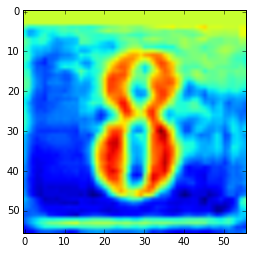

Labels [3 0]
Dtype float32
Shape (56, 56)
Color range -0.51809 0.5


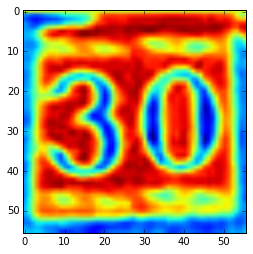

Labels [6 5]
Dtype float32
Shape (56, 56)
Color range -0.533049 0.5


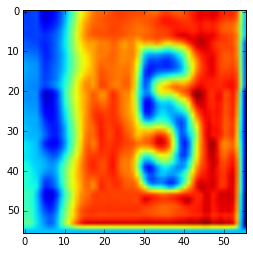

Labels [1 8]
Dtype float32
Shape (56, 56)
Color range -0.478832 0.5


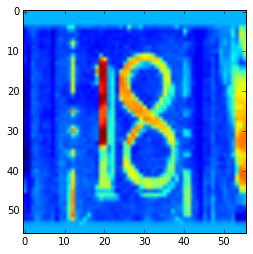

Labels [2 4]
Dtype float32
Shape (56, 56)
Color range -0.506588 0.5


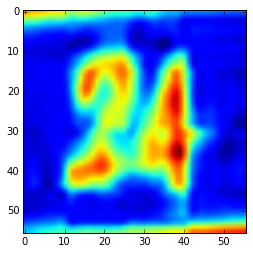

Labels [1 2]
Dtype float32
Shape (56, 56)
Color range -0.476377 0.5


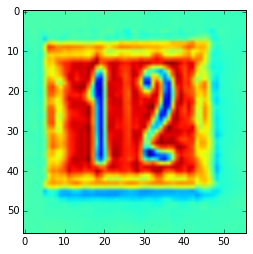

In [35]:
#
# Lets check our dataset
#
for dataset, labels in [(train_dataset_56, train_labels),
                        (valid_dataset_56, valid_labels),
                        (test_dataset_56, test_labels)]:
    show_images(dataset, labels, 2)

Training set (26259, 56, 56, 1) (26259, 5, 11)
Validation set (2000, 56, 56, 1) (2000, 5, 11)
Test set (13068, 56, 56, 1) (13068, 5, 11)
Labels [[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Dtype float32
Shape (56, 56, 1)
Color range -0.525951 0.5


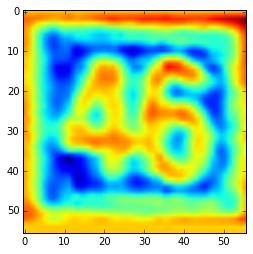

Labels [[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Dtype float32
Shape (56, 56, 1)
Color range -0.5455 0.5


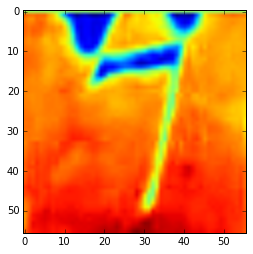

In [36]:
#
# Format our labels using one hot encoding, and add a space character
#
num_labels = 11 # Add an extra character so we can deal with spaces
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([np.array([(np.arange(num_labels) == l).astype(np.float32) 
                        for l in np.append(row, [num_labels-1] * (num_digits - len(row)), 0)])
              for row in labels])
    return dataset_output, labels_output

train_dataset_56, train_labels = reformat(train_dataset_56, train_labels)
valid_dataset_56, valid_labels = reformat(valid_dataset_56, valid_labels)
test_dataset_56, test_labels = reformat(test_dataset_56, test_labels)

print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape)

for dataset, labels in [(train_dataset_56, train_labels)]:
    show_images(dataset, labels, 2)

In [37]:
#
# Create datasets of smaller images so we can do better testing
#
#Limit test set as it's killing the box
test_dataset_56 = test_dataset_56[:6000]
test_labels = test_labels[:6000]

# Create a pit sized 
train_dataset_28 = train_dataset_56[:, ::2, ::2, :]
valid_dataset_28 = valid_dataset_56[:, ::2, ::2, :]
test_dataset_28 = test_dataset_56[:, ::2, ::2, :]
print('Training set', train_dataset_28.shape, train_labels.shape)
print('Validation set', valid_dataset_28.shape, valid_labels.shape)
print('Test set', test_dataset_28.shape, test_labels.shape)

Training set (26259, 28, 28, 1) (26259, 5, 11)
Validation set (2000, 28, 28, 1) (2000, 5, 11)
Test set (6000, 28, 28, 1) (6000, 5, 11)


In [38]:
#
# Helper variables and functions
#
dataset_56 = (train_dataset_56, valid_dataset_56, test_dataset_56)
dataset_28 = (train_dataset_28, valid_dataset_28, test_dataset_28)

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_list(predictions, labels):
    result = np.mean([accuracy(predictions[i],
                               labels[:, i, :])
                        for i in range(num_digits)])
    return result

In [39]:
#
# Our main training loop
#

def run_graph(graph, train_dataset):
    if test_graphs: return
    start_time = time.time()
        
    batch_size=16
    
    num_steps = 1000001
    save_steps = 100000
    eval_steps = 100
    valid_steps = 1000
    # Use a timeout to stop the training
    timeout =  1 * 60 # 30 minutes * 60 seconds
    
    # Get the tensors from the graph
    tf_train_dataset = graph.get_tensor_by_name('tf_train_dataset:0')
    tf_train_labels = [graph.get_tensor_by_name('tf_train_labels_%d:0' % i) for i in range(num_digits)]
    train_prediction = [graph.get_tensor_by_name('train_prediction_%d:0' % i) for i in range(num_digits)]
    valid_prediction = [graph.get_tensor_by_name('valid_prediction_%d:0' % i) for i in range(num_digits)]
    test_prediction = [graph.get_tensor_by_name('test_prediction_%d:0' % i) for i in range(num_digits)]
    optimizer = graph.get_tensor_by_name('optimizer:0')
    loss = graph.get_tensor_by_name('loss:0')
    learning_rate = graph.get_tensor_by_name('learning_rate:0')
    
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()

        print('Initialized')
        
        # Lets run until we finish all the training images
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]


            feed_dict = {tf_train_labels[i] : batch_labels[:, i, :] for i in range(num_digits)}
            feed_dict[tf_train_dataset] = batch_data        


            fetches = [optimizer, loss]
            results = session.run(fetches, feed_dict=feed_dict)


            elapsed_time = time.time() - start_time
            timeup = elapsed_time >= timeout
            
            if step > 0 or timeup:
                if (step % eval_steps == 0 or timeup):
                    print('Elapsed time(s):%d/%d (%.2f%%)' % (elapsed_time, timeout, 1.0 * elapsed_time / timeout))
                    if timeup:
                        print("\nTIMEUP!")
                    print('Learning rate:', learning_rate.eval())
                    print('Minibatch loss at step %d: %f' % (step, results[1]))

                    fetches = train_prediction
                    results = session.run(fetches, feed_dict={tf_train_dataset : batch_data})
                    train_accuracy = accuracy_list(
                        results,
                        batch_labels)

                    print('Minibatch accuracy: %.1f%%' % train_accuracy)
            
                if (step % valid_steps == 0 or timeup):
                    valid_accuracy = accuracy_list(
                        [valid_prediction[i].eval() for i in range(num_digits)],
                        valid_labels)
                    print('Validation accuracy: %.1f%%' % valid_accuracy)

                if step % save_steps == 0 or timeup:
                    test_accuracy = accuracy_list(
                        [test_prediction[i].eval() for i in range(num_digits)],
                        test_labels)
                    print('Test accuracy: %.1f%%' % test_accuracy)
                    
            if timeup:
                break

        print("Creating outputs")
    #     output = {
    #         'layer_1' : layer1_weights.eval(),
    #         'layer_2' : layer2_weights.eval(),
    #         'layer_3' : layer3_weights.eval(),
    #     }
    print("Finished")

In [40]:
#
# Our graph creation function
#
def create_graph(valid_dataset, test_dataset,
                 use_dropout=False,
                 learning_rate=0.05,
                 learning_decay=0.596,
                 use_max_pool=False):
    batch_size = 16

    patch_size = 5
    depth = 16

    # Taken from tensorflow tutorial
    num_hidden = 64

    graph = tf.Graph()
    stddev = 0.1

    img_height, img_width = test_dataset[0].shape[:2]

    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                           img_height,
                                                           img_width,
                                                           num_channels), name="tf_train_dataset")

        tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                             num_labels), name="tf_train_labels_%d" % i)
                           for i in range(num_digits)]

        # Variables.
        layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                        patch_size,
                                                        num_channels,
                                                        depth], stddev=stddev), name="layer1_weights")
        layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

        tmp_size = img_width * img_height * depth
        if use_max_pool: tmp_size = int(tmp_size / 4.)
        layer2_weights = tf.Variable(tf.truncated_normal([tmp_size, num_hidden], stddev=stddev),
                                     name="layer2_weights")
        layer2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer2_biases")


        layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                        num_labels * num_digits], stddev=stddev), name="layer4_weights")
        layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

        # Model.
        def model(data, dropout=False):
            if dropout: data = tf.nn.dropout(data, 0.9)

            conv = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
            if use_max_pool: conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            if dropout: conv = tf.nn.dropout(conv, 0.75)

            shape = conv.get_shape().as_list()
            reshape = tf.reshape(conv, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer2_weights) + layer2_biases)
            if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
            output = tf.matmul(hidden, layer4_weights) + layer4_biases

            split_logits = tf.split(1, num_digits, output)
            return split_logits

        # Training computation.
        logits = model(tf_train_dataset, use_dropout)

        # Training computation.
        logits = model(tf_train_dataset)

        loss = tf.reduce_mean([
                            tf.nn.softmax_cross_entropy_with_logits(
                                logits[i],
                                tf_train_labels[i]
                            )for i in range(num_digits)], name='loss')


        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(learning_rate, 
                                                   global_step, 
                                                   100000, 
                                                   learning_decay, 
                                                   name='learning_rate')
        optimizer = tf.train.GradientDescentOptimizer(learning_rate, 
                                                      name='optimizer').minimize(loss, 
                                                                                 global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]
                                         ,name="train_prediction_%d" % i) for i in range(num_digits)]

        tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
        valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]
                                         ,name="valid_prediction_%d" % i) for i in range(num_digits)]

        tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")
        test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]
                                         ,name="test_prediction_%d" % i) for i in range(num_digits)]
    return graph

In [41]:
test_graphs=False

In [42]:
#
# Run a basic graph configuration
#
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset) 
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):3/60 (0.06%)
Learning rate: 0.0499739
Minibatch loss at step 100: 1.074699
Minibatch accuracy: 71.2%
Elapsed time(s):5/60 (0.10%)
Learning rate: 0.049948
Minibatch loss at step 200: 1.156034
Minibatch accuracy: 67.5%
Elapsed time(s):8/60 (0.14%)
Learning rate: 0.0499222
Minibatch loss at step 300: 1.240865
Minibatch accuracy: 61.2%
Elapsed time(s):10/60 (0.18%)
Learning rate: 0.0498963
Minibatch loss at step 400: 1.308487
Minibatch accuracy: 56.2%
Elapsed time(s):13/60 (0.22%)
Learning rate: 0.0498705
Minibatch loss at step 500: 1.309378
Minibatch accuracy: 61.2%
Elapsed time(s):15/60 (0.26%)
Learning rate: 0.0498447
Minibatch loss at step 600: 1.100266
Minibatch accuracy: 63.8%
Elapsed time(s):18/60 (0.31%)
Learning rate: 0.0498189
Minibatch loss at step 700: 1.207100
Minibatch accuracy: 60.0%
Elapsed time(s):20/60 (0.35%)
Learning rate: 0.0497932
Minibatch loss at step 800: 1.173720
Minibatch accuracy: 62.5%
Elapsed time(s):23/60 (0.39%)
Learning rate: 0.0

In [44]:
#
# Run a complex configuration
#
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.5)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):1/60 (0.03%)
Learning rate: 0.499739
Minibatch loss at step 100: 1.050751
Minibatch accuracy: 70.0%
Elapsed time(s):3/60 (0.06%)
Learning rate: 0.49948
Minibatch loss at step 200: 1.087827
Minibatch accuracy: 72.5%
Elapsed time(s):4/60 (0.08%)
Learning rate: 0.499222
Minibatch loss at step 300: 1.139140
Minibatch accuracy: 66.2%
Elapsed time(s):6/60 (0.10%)
Learning rate: 0.498963
Minibatch loss at step 400: 1.062648
Minibatch accuracy: 68.8%
Elapsed time(s):7/60 (0.13%)
Learning rate: 0.498705
Minibatch loss at step 500: 1.072880
Minibatch accuracy: 73.8%
Elapsed time(s):9/60 (0.15%)
Learning rate: 0.498447
Minibatch loss at step 600: 0.769234
Minibatch accuracy: 85.0%
Elapsed time(s):10/60 (0.18%)
Learning rate: 0.498189
Minibatch loss at step 700: 0.777481
Minibatch accuracy: 85.0%
Elapsed time(s):12/60 (0.20%)
Learning rate: 0.497932
Minibatch loss at step 800: 0.828014
Minibatch accuracy: 81.2%
Elapsed time(s):13/60 (0.23%)
Learning rate: 0.497674
Minib